# Palladium/Platinum Trading Opportunities 
## Part 1: Mean Reverting Strategy

Gold, silver, palladium and platinum are four of the most widely traded precious metals with vast applications and also form the bedrock for financial investments within the commodties complex. In part 1 of this project we focus on seeking out potential mean reverting opportunities between palladium and platinum prices given their subtitutability in industrial applications primarily within the automotive production space.

Before we delve into our time series analysis and machine learning analysis later on in the project, it behoves us to take a deeper look into the pricing mechanism of these two precious metals. Centered around independently adminstered auctions by the London Metal Exchange (LME), prices for these metals are fixed twice daily at 0945 and 1400 (London BST) everyday in US dollars per .9995 fine ounces. In those hours of the day, four elected members of the LPPM (London palladium and platinum market) set the offer price to be taken by the remaining members. This auction process is fully compliant with IOSCO Principles for Financial Benchmarks and the prices are internationally regarded as the pricing mechanism for different precious metal transactions and products. Finally, it should be noted that Sterling and Euro prices are also available but are used as indicative prices for settlement only.

In Part 1 of this project, we will look at devising a mean reverting strategy based on time series data before looking into machine learing techniques to further analyse fundamental factors for creating a trade decision filter for the next period in Part 2. The full data set is taken from quandl and dates back for more than 20 years. It should be noted that several economic regime changes took place during this period due to extended periods of low interest rates between 2009-2019, supply/demand shocks and technological advancement.

## 1. Importing basic Python packages

We begin by importing some of the basic packages in Python and downloading the data set from quandl.

In [1]:
# importing data source
#!pip install quandl
#!pip install arch
import quandl
quandl.ApiConfig.api_key = "gPQy5P9SCNJCN5PJWi4z"

# importing basic python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# importing common statsmodels functinos for time-series analysis
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.seasonal import seasonal_decompose

# defining the period of analysis
start_date='2009-01-01'
end_date='2021-04-09'

# import data through api
pall = quandl.get('LPPM/PALL', start_date=start_date, end_date=end_date)
plat = quandl.get('LPPM/PLAT', start_date=start_date, end_date=end_date)

## 2. Palladium

Next, we perform exploratory data analysis (EDA) on Palladium prices to first gain a better understanding of the price action in this market. Palladium is a lustrous white material, one of the six platinum-group metals. About 85% of palladium ends up in the exhaust systems in cars, where it helps turn toxic pollutants into less-harmful carbon dioxide and water vapor. It is also used in electronics, dentistry and jewelry. The metal is mined primarily in Russia and South Africa, and mostly extracted as a secondary product from operations that are focused on other metals, such as platinum or nickel. As a result, supply usually lag prices which have increased substantially in recent years due to strong demand as consumers move away from diesel cars (which use more platinum) into gasoline powered vehicles which use palladium.

### 2.1 Palladium Exploratory Data Analysis

In [2]:
# explore and clean up data
print(pall.info())
print('\n')
print(pall.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3092 entries, 2009-01-02 to 2021-04-08
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD AM  3092 non-null   float64
 1   EUR AM  3092 non-null   float64
 2   GBP AM  3092 non-null   float64
 3   USD PM  3073 non-null   float64
 4   EUR PM  3074 non-null   float64
 5   GBP PM  3074 non-null   float64
dtypes: float64(6)
memory usage: 169.1 KB
None


            USD AM   EUR AM   GBP AM  USD PM   EUR PM   GBP PM
Date                                                          
2021-03-31  2627.0  2236.70  1907.77  2625.0  2239.76  1907.70
2021-04-01  2630.0  2243.07  1909.26  2640.0  2245.85  1914.43
2021-04-06  2674.0  2265.14  1930.69  2664.0  2251.90  1925.55
2021-04-07  2628.0  2211.19  1900.90  2632.0  2214.56  1912.10
2021-04-08  2614.0  2201.26  1903.86  2650.0  2228.76  1925.87


In [3]:
# focusing only on USD price information
pall_usd = pall[['USD AM','USD PM']]
print(pall_usd.tail())
print('\n')

# check for null values
print(pall_usd.isnull().sum())

            USD AM  USD PM
Date                      
2021-03-31  2627.0  2625.0
2021-04-01  2630.0  2640.0
2021-04-06  2674.0  2664.0
2021-04-07  2628.0  2632.0
2021-04-08  2614.0  2650.0


USD AM     0
USD PM    19
dtype: int64


In [4]:
# examine the null values
print(pall_usd[pall_usd['USD PM'].isnull()])

# create index for checking after filling values
check = pall_usd[pall_usd['USD PM'].isnull()].index

            USD AM  USD PM
Date                      
2009-12-24   377.0     NaN
2009-12-31   402.0     NaN
2010-12-24   764.0     NaN
2010-12-31   791.0     NaN
2011-12-23   653.0     NaN
2011-12-30   636.0     NaN
2012-12-24   683.0     NaN
2012-12-31   699.0     NaN
2013-12-24   696.0     NaN
2013-12-31   711.0     NaN
2014-12-24   809.0     NaN
2014-12-31   798.0     NaN
2015-12-24   554.0     NaN
2015-12-31   547.0     NaN
2016-12-23   654.0     NaN
2016-12-30   676.0     NaN
2018-12-24  1240.0     NaN
2020-12-24  2328.0     NaN
2020-12-31  2370.0     NaN


In [5]:
# clean data to remove null values
'''
Set USD PM = USD AM since these PM missing values occured on Christmas/New Year eve where more offices around the world worked for half a day so it's reasonable to assume 
that the values are the same on these days especially when liquidity is also very light
'''
pall_usd['USD PM'].fillna(pall_usd['USD AM'].copy(), inplace=True)

C:\Users\RyanK\anaconda3\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [6]:
# check to ensure that null values were correctly filled
print(pall_usd.loc[check])
print('\n')

# set data freq to business days after original null values are filled
pall_usd = pall_usd.asfreq('B', method='bfill')
print(pall_usd.info())

            USD AM  USD PM
Date                      
2009-12-24   377.0   377.0
2009-12-31   402.0   402.0
2010-12-24   764.0   764.0
2010-12-31   791.0   791.0
2011-12-23   653.0   653.0
2011-12-30   636.0   636.0
2012-12-24   683.0   683.0
2012-12-31   699.0   699.0
2013-12-24   696.0   696.0
2013-12-31   711.0   711.0
2014-12-24   809.0   809.0
2014-12-31   798.0   798.0
2015-12-24   554.0   554.0
2015-12-31   547.0   547.0
2016-12-23   654.0   654.0
2016-12-30   676.0   676.0
2018-12-24  1240.0  1240.0
2020-12-24  2328.0  2328.0
2020-12-31  2370.0  2370.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3200 entries, 2009-01-02 to 2021-04-08
Freq: B
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD AM  3200 non-null   float64
 1   USD PM  3200 non-null   float64
dtypes: float64(2)
memory usage: 75.0 KB
None


In [7]:
# descriptive statistics of data
print(pall_usd.describe())
print('\n')

# number of observations per year
for n in range(2009,2021):
    print('Number of observations in {} is {}'.format(n, len(pall_usd.loc[str(n)])))

print('\n')    

# max and min prices over the series
max_price = pall_usd[pall_usd['USD PM'] == pall_usd['USD PM'].max()]
min_price = pall_usd[pall_usd['USD PM'] == pall_usd['USD PM'].min()]

print('Date of maximum PALL PM prices')
print(max_price)
print('\n')
print('Date of minimum PALL PM prices')
print(min_price)

            USD AM       USD PM
count  3200.000000  3200.000000
mean    920.709219   920.735781
std     548.009975   546.910517
min     177.000000   179.000000
25%     619.750000   620.000000
50%     753.750000   754.000000
75%     981.000000   982.250000
max    2795.000000  2781.000000


Number of observations in 2009 is 260
Number of observations in 2010 is 261
Number of observations in 2011 is 260
Number of observations in 2012 is 261
Number of observations in 2013 is 261
Number of observations in 2014 is 261
Number of observations in 2015 is 261
Number of observations in 2016 is 261
Number of observations in 2017 is 260
Number of observations in 2018 is 261
Number of observations in 2019 is 261
Number of observations in 2020 is 262


Date of maximum PALL PM prices
            USD AM  USD PM
Date                      
2020-02-19  2786.0  2781.0


Date of minimum PALL PM prices
            USD AM  USD PM
Date                      
2009-01-15   177.0   179.0


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


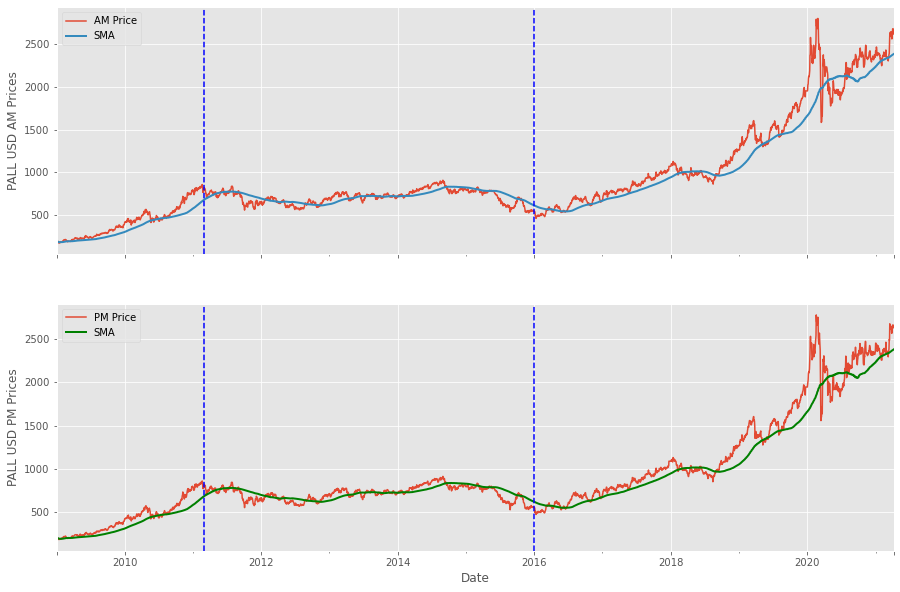

In [8]:
# plot time series of price action
print(plt.style.available)
plt.style.use('ggplot')
fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)

pall_usd['USD AM'].plot(label='AM Price', ax=ax[0])
pall_usd['USD AM'].rolling('200D').mean().plot(linewidth=2, label='SMA', ax=ax[0])
ax[0].axvline('2011-03', linestyle='--', c='blue')
ax[0].axvline('2016', linestyle='--', c='blue')
ax[0].set_ylabel('PALL USD AM Prices')
ax[0].legend()

pall_usd['USD PM'].plot(label='PM Price', ax=ax[1])
pall_usd['USD PM'].rolling('200D').mean().plot(linewidth=2, label='SMA', ax=ax[1], c='green')
ax[1].axvline('2011-03', linestyle='--', c='blue')
ax[1].axvline('2016', linestyle='--', c='blue')
ax[1].set_ylabel('PALL USD PM Prices')
ax[1].legend()

plt.show()

### Observation 1

There were about 260 business days in each full calendar year. Across the current data set, we had a total of 3200 observations and the mean Palladium price was USD920 with a standard deviation of USD546 based on PM prices. The highest price of USD2,786 (AM price) was attained on 2020-02-19 while the lowest of USD177 (AM price) in 2009-01-15. Palladium price action between 2009 to 2020 can be characterised into three periods: 1.) gentle uptrend between Jan 2009 and Mar 2011, 2.) consolidation from Mar 2011 to Jan 2016 and 3.) steep uptrend from Jan 2016 to early 2021. After dropping significantly at the begining of 2020 due to Covid-19, it has since retraced most of its losses. We will focus on the price action starting from 2016 through to 2021 next as it is more recent.

### 2.2 Palladium Statistical Analysis

            USD AM  USD PM
Date                      
2016-01-01   547.0   550.0
2016-01-04   547.0   550.0
2016-01-05   545.0   544.0
2016-01-06   532.0   519.0
2016-01-07   496.0   486.0
            USD AM  USD PM
Date                      
2021-04-02  2674.0  2664.0
2021-04-05  2674.0  2664.0
2021-04-06  2674.0  2664.0
2021-04-07  2628.0  2632.0
2021-04-08  2614.0  2650.0


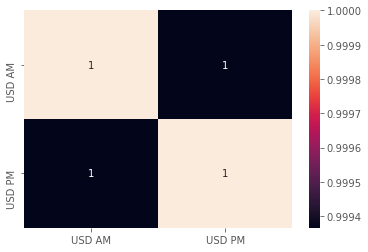

In [9]:
# slicing out data from 2016 onwards
pall_usd = pall_usd.loc['2016':'2021']

print(pall_usd.head())
print(pall_usd.tail())

# plot autocorrelation heatmap
sns.heatmap(pall_usd.corr(), annot=True)
plt.show()

As AM/PM fixing prices were perfectly correlated, we will focus only on the PM prices to simplify the analysis and begin by testing for unit root in the process.

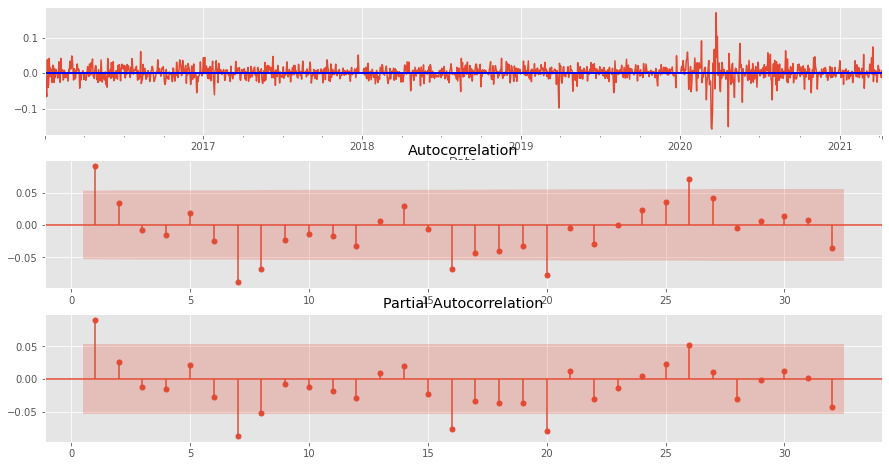

In [10]:
# rename price columns for consistency
pall_usd.rename(columns={'USD AM': 'pall_am', 'USD PM': 'pall_pm'}, inplace=True)

# plotting the first difference of log-returns
fig, ax = plt.subplots(3, 1, figsize=(15,8))
log_ret = pall_usd['pall_pm'].apply(np.log).diff().dropna()
log_ret.plot(ax=ax[0])
ax[0].axhline(0, c='blue', linewidth=2)

# plot pacf and acf for daily returns
plot_acf(log_ret, zero=False, ax=ax[1])
plot_pacf(log_ret, zero=False, ax=ax[2])

plt.show()

In [11]:
# test for unit root in price data
result = adfuller(pall_usd['pall_pm'])
print('Adfuller test statistics is {} with a p-value of {}'.format(result[0], result[1]))
print('\n')
print(result)
print('\n')

# determine optimal order for ARIMA model
for p in range(3):
    for q in range(3):
        try:
            model = SARIMAX(pall_usd['pall_pm'], order=(p,1,q))
            result = model.fit()
            aic = result.aic
            bic = result.bic
            print(p, q, aic, bic)
        except:
            print(p, q, None, None)

Adfuller test statistics is 0.43833458357088445 with a p-value of 0.9828732803052513


(0.43833458357088445, 0.9828732803052513, 20, 1354, {'1%': -3.4351888040389302, '5%': -2.8636769637158244, '10%': -2.5679077212657284}, 13332.447698178123)


0 0 13614.218717299915 13619.444198772697
0 1 13600.952658640086 13611.40362158565
0 2 13596.669033180935 13612.345477599281
1 0 13599.171367340605 13609.622330286169
1 1 13598.65088006039 13614.327324478736
1 2 13598.615319016333 13619.517244907462
2 0 13597.318645976597 13612.995090394943
2 1 13599.29097073188 13620.192896623008
2 2 13593.576201765196 13619.703609129107


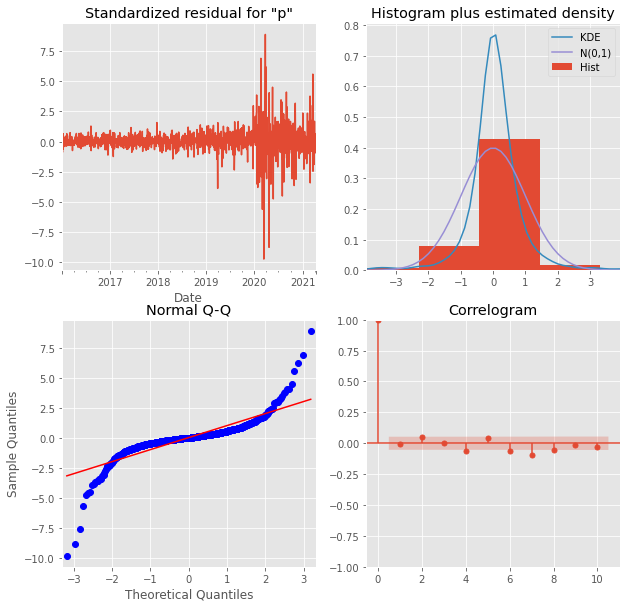

                               SARIMAX Results                                
Dep. Variable:                pall_pm   No. Observations:                 1375
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6797.586
Date:                Sun, 11 Apr 2021   AIC                          13599.171
Time:                        22:43:48   BIC                          13609.622
Sample:                    01-01-2016   HQIC                         13603.082
                         - 04-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1110      0.010     11.240      0.000       0.092       0.130
sigma2      1161.4610     13.226     87.814      0.000    1135.538    1187.384
Ljung-Box (L1) (Q):                   0.08   Jarque-

In [12]:
# fitting a ARIMA model to the data using the general SARIMAX class
model1 = SARIMAX(pall_usd['pall_pm'], order=(1,1,0))
result1 = model1.fit()

# model diagnosis
result1.plot_diagnostics(figsize=(10,10))
plt.show()

print(result1.summary())

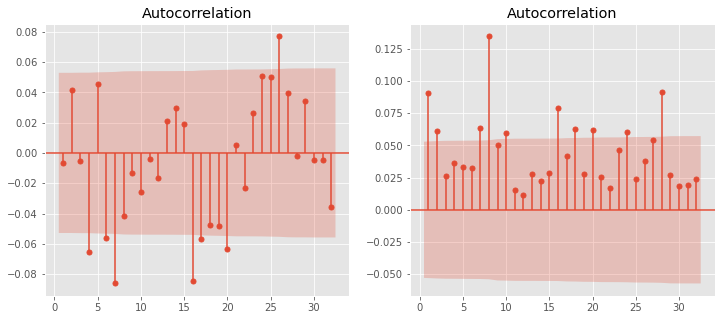

In [13]:
# plotting the ACF of the fitted model residuals
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_acf(result1.resid, zero=False, ax=ax[0]);
plot_acf(result1.resid**2, zero=False, ax=ax[1]);

plt.show()

### Observation 2

Based on the adfuller test statistics, we cannot reject the null hypothesis of unit root present in the price time series, and a plot of PALL PM log returns resembles white noise with its corresponding ACF and PACF showing some degree of autocorrelation among higher lags. We tried to characterize the time series with an ARIMA(1,1,0), which means that n period return could be correlated with n-1 period return, based on AIC and BIC values. For this model, Prob(Q) > 0.05 rejects the null hypothesis that the errors in the model are correlated. However, both the histogram and Prob(JB) < 0.05 show that errors not normally distributed. This could imply some degree of volatility clustering which an ARIMA(1,1,0) model cannot fully capture and is better suited for GRACH modelling.

## 3. Platinum

Platinum is a dense, malleable metal represented by the symbol Pt.. This metal is ductile, corrosion resistant, and highly unreactive with a very high melting point. The largest producers of platinum are South Africa and Russia. A small amount of this gray-white metal is produced every year because it is not commonly found in the Earth's crust. The largest application of platinum is manufacturing catalytic converters in vehicular emission control units. Almost half the platinum produced is used by this industry. Also, spark plugs, dental work, medical instruments, and cancer medications are made with platinum.

### 3.1 Platinum Exploratory Data Analysis

In [14]:
# plat data exploratory analysis
print(plat.info())
print('\n')
print(plat.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3094 entries, 2009-01-02 to 2021-04-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD AM  3094 non-null   float64
 1   EUR AM  3094 non-null   float64
 2   GBP AM  3094 non-null   float64
 3   USD PM  3074 non-null   float64
 4   EUR PM  3076 non-null   float64
 5   GBP PM  3076 non-null   float64
dtypes: float64(6)
memory usage: 169.2 KB
None


            USD AM   EUR AM  GBP AM  USD PM   EUR PM  GBP PM
Date                                                        
2021-04-01  1189.0  1014.07  863.16  1199.0  1019.99  869.47
2021-04-06  1206.0  1021.60  870.76  1221.0  1032.12  882.54
2021-04-07  1238.0  1041.65  895.48  1241.0  1044.17  901.56
2021-04-08  1229.0  1034.95  895.12  1223.0  1028.60  888.81
2021-04-09  1213.0  1020.61  885.08  1203.0  1013.48  876.82


In [15]:
# extracting only the USD based information
plat_usd = plat[['USD AM','USD PM']]
print(plat_usd.tail())

            USD AM  USD PM
Date                      
2021-04-01  1189.0  1199.0
2021-04-06  1206.0  1221.0
2021-04-07  1238.0  1241.0
2021-04-08  1229.0  1223.0
2021-04-09  1213.0  1203.0


In [16]:
# check for null values
print(plat_usd.isnull().sum())

USD AM     0
USD PM    20
dtype: int64


In [17]:
# identify where the null values come from
print(plat_usd[plat_usd['USD PM'].isnull()])

# create index for checking after filling values
check2 = plat_usd[plat_usd['USD PM'].isnull()].index

            USD AM  USD PM
Date                      
2009-12-24  1456.0     NaN
2009-12-31  1466.0     NaN
2010-12-24  1725.0     NaN
2010-12-31  1731.0     NaN
2011-12-23  1436.0     NaN
2011-12-30  1381.0     NaN
2012-12-24  1543.0     NaN
2012-12-31  1523.0     NaN
2013-12-24  1327.0     NaN
2013-12-31  1358.0     NaN
2014-12-24  1190.0     NaN
2014-12-31  1210.0     NaN
2015-12-24   874.0     NaN
2015-12-31   872.0     NaN
2016-12-23   905.0     NaN
2016-12-30   907.0     NaN
2018-12-24   792.0     NaN
2018-12-31   794.0     NaN
2020-12-24  1021.0     NaN
2020-12-31  1075.0     NaN


In [18]:
# clean data to remove null values
'''
Set USD PM = USD AM since these PM missing values occured on Christmas/New Year eves 
where more offices around the world worked for half a day so it's reasonable to assume 
that the values are the same on these days especially when liquidity is also very light
'''
plat_usd['USD PM'].fillna(plat_usd['USD AM'].copy(), inplace=True)

C:\Users\RyanK\anaconda3\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [19]:
# check to ensure that null values were correctly filled
print(plat_usd.loc[check2])
print('\n')

# set data freq to business days after original null values are filled
plat_usd = plat_usd.asfreq('B', method='bfill')
print(plat_usd.info())

            USD AM  USD PM
Date                      
2009-12-24  1456.0  1456.0
2009-12-31  1466.0  1466.0
2010-12-24  1725.0  1725.0
2010-12-31  1731.0  1731.0
2011-12-23  1436.0  1436.0
2011-12-30  1381.0  1381.0
2012-12-24  1543.0  1543.0
2012-12-31  1523.0  1523.0
2013-12-24  1327.0  1327.0
2013-12-31  1358.0  1358.0
2014-12-24  1190.0  1190.0
2014-12-31  1210.0  1210.0
2015-12-24   874.0   874.0
2015-12-31   872.0   872.0
2016-12-23   905.0   905.0
2016-12-30   907.0   907.0
2018-12-24   792.0   792.0
2018-12-31   794.0   794.0
2020-12-24  1021.0  1021.0
2020-12-31  1075.0  1075.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3201 entries, 2009-01-02 to 2021-04-09
Freq: B
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD AM  3201 non-null   float64
 1   USD PM  3201 non-null   float64
dtypes: float64(2)
memory usage: 75.0 KB
None


In [20]:
# descriptive statistics of data
print(plat_usd.describe())
print('\n')

# number of observations per year
for n in range(2009,2021):
    print('Number of observations in {} is {}'.format(n, len(plat_usd.loc[str(n)])))

print('\n')    

# max and min prices over the series
max_price = plat_usd[plat_usd['USD PM'] == plat_usd['USD PM'].max()]
min_price = plat_usd[plat_usd['USD PM'] == plat_usd['USD PM'].min()]

print('Date of maximum PLAT PM prices')
print(max_price)
print('\n')
print('Date of minimum PLAT PM prices')
print(min_price)

            USD AM       USD PM
count  3201.000000  3201.000000
mean   1214.128085  1213.252734
std     316.837300   316.838601
min     607.000000   593.000000
25%     934.000000   933.000000
50%    1143.000000  1144.000000
75%    1491.000000  1492.000000
max    1899.000000  1887.000000


Number of observations in 2009 is 260
Number of observations in 2010 is 261
Number of observations in 2011 is 260
Number of observations in 2012 is 261
Number of observations in 2013 is 261
Number of observations in 2014 is 261
Number of observations in 2015 is 261
Number of observations in 2016 is 261
Number of observations in 2017 is 260
Number of observations in 2018 is 261
Number of observations in 2019 is 261
Number of observations in 2020 is 262


Date of maximum PLAT PM prices
            USD AM  USD PM
Date                      
2011-08-22  1894.0  1887.0


Date of minimum PLAT PM prices
            USD AM  USD PM
Date                      
2020-03-19   607.0   593.0


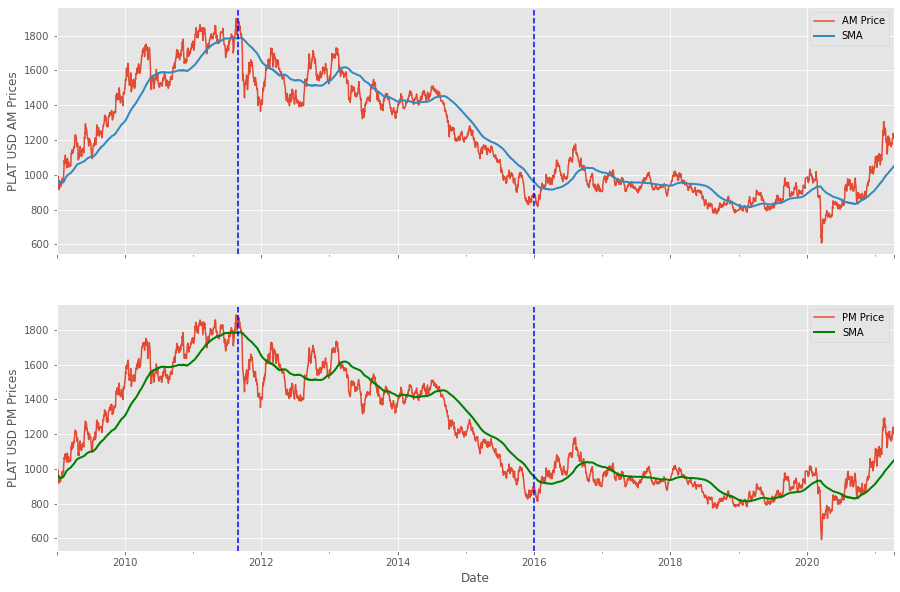

In [21]:
# plot time series of price action
fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)

plat_usd['USD AM'].plot(label='AM Price', ax=ax[0])
plat_usd['USD AM'].rolling('200D').mean().plot(linewidth=2, label='SMA', ax=ax[0])
ax[0].axvline('2011-09', linestyle='--', c='blue')
ax[0].axvline('2016', linestyle='--', c='blue')
ax[0].set_ylabel('PLAT USD AM Prices')
ax[0].legend()

plat_usd['USD PM'].plot(label='PM Price', ax=ax[1])
plat_usd['USD PM'].rolling('200D').mean().plot(linewidth=2, label='SMA', ax=ax[1], c='green')
ax[1].axvline('2011-09', linestyle='--', c='blue')
ax[1].axvline('2016', linestyle='--', c='blue')
ax[1].set_ylabel('PLAT USD PM Prices')
ax[1].legend()

plt.show()

### Observation 3

There were about 260 business days in each full calendar year for the Platinum time series. Across the current data set, we had a total of 3201 observations and the mean Palladium price was USD1213 with a standard deviation of USD316 based on PM prices. This represents a higher mean price and smaller standard deviation compared to Palladium. The highest price of USD1,894 (AM price) was attained on 2011-08-22 while the lowest of USD593 (PM price) in 2020-03-19. Platinum price action between 2009 to 2020 can be characterised into three periods: 1.) strong uptrend between Jan 2009 and Sep 2011 2.) down trend from Sep 2011 to Jan 2016 and 3.) consolidation from Jan 2016 to early 2020. Again, we will focus on the data from 2016 given its recency.

### 3.2 Platinum Statistical Analysis

            USD AM  USD PM
Date                      
2016-01-01   878.0   893.0
2016-01-04   878.0   893.0
2016-01-05   890.0   893.0
2016-01-06   885.0   873.0
2016-01-07   869.0   865.0
            USD AM  USD PM
Date                      
2021-04-05  1206.0  1221.0
2021-04-06  1206.0  1221.0
2021-04-07  1238.0  1241.0
2021-04-08  1229.0  1223.0
2021-04-09  1213.0  1203.0


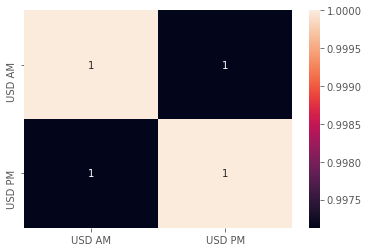

In [22]:
# slicing out data from 2016 onwards
plat_usd = plat_usd.loc['2016':'2021']

print(plat_usd.head())
print(plat_usd.tail())

# plot autocorrelation heatmap
sns.heatmap(plat_usd.corr(), annot=True)
plt.show()

As AM/PM fixing prices were perfectly correlated, we will focus only on the PM prices to simplify the analysis and begin by testing for unit root in the process.

In [23]:
# rename price columns for consistency
plat_usd.rename(columns={'USD AM': 'plat_am', 'USD PM': 'plat_pm'}, inplace=True)

# test for unit root in price data
result = adfuller(plat_usd['plat_pm'])
print('Adfuller test statistics is {} with a p-value of {}'.format(result[0], result[1]))
print('\n')
print(result)

Adfuller test statistics is -1.8077383473071866 with a p-value of 0.37662664336508717


(-1.8077383473071866, 0.37662664336508717, 7, 1368, {'1%': -3.435139190725917, '5%': -2.8636550704859007, '10%': -2.5678960623995417}, 11050.499010646496)


0 0 11256.825168846728 11262.05137785683
0 1 11258.705851290713 11269.158269310914
0 2 11256.071671272357 11271.750298302659
1 0 11258.692387369014 11269.144805389215
1 1 11258.559510265324 11274.238137295626
1 2 11256.616811541287 11277.52164758169
2 0 11256.256466408762 11271.935093439064
2 1 11257.370591036259 11278.275427076662
2 2 11251.170777766905 11277.301822817408


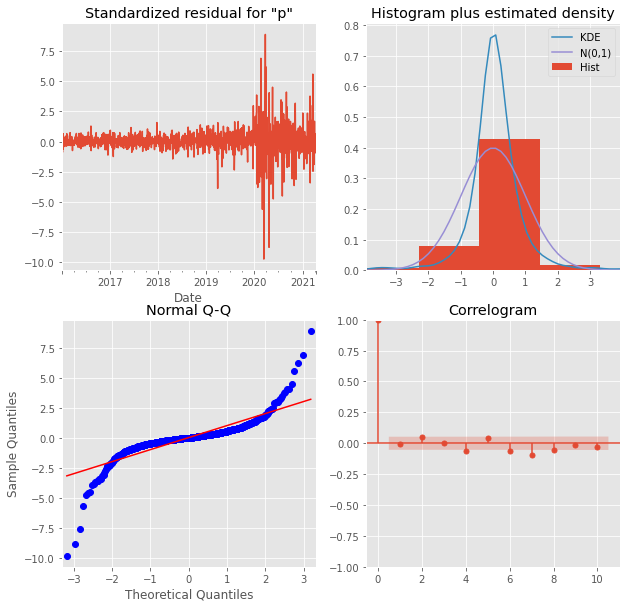

                               SARIMAX Results                                
Dep. Variable:                pall_pm   No. Observations:                 1375
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6797.586
Date:                Sun, 11 Apr 2021   AIC                          13599.171
Time:                        22:43:53   BIC                          13609.622
Sample:                    01-01-2016   HQIC                         13603.082
                         - 04-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1110      0.010     11.240      0.000       0.092       0.130
sigma2      1161.4610     13.226     87.814      0.000    1135.538    1187.384
Ljung-Box (L1) (Q):                   0.08   Jarque-

In [24]:
# determine optimal order for ARIMA model
for p in range(3):
    for q in range(3):
        try:
            model = SARIMAX(plat_usd['plat_pm'], order=(p,1,q))
            result = model.fit()
            aic = result.aic
            bic = result.bic
            print(p, q, aic, bic)
        except:
            print(p, q, None, None)

# fitting a ARIMA model to the data using the general SARIMAX class
model2 = SARIMAX(plat_usd['plat_pm'], order=(0,1,0))
result2 = model1.fit()

# model diagnosis
result2.plot_diagnostics(figsize=(10,10))
plt.show()

print(result2.summary())

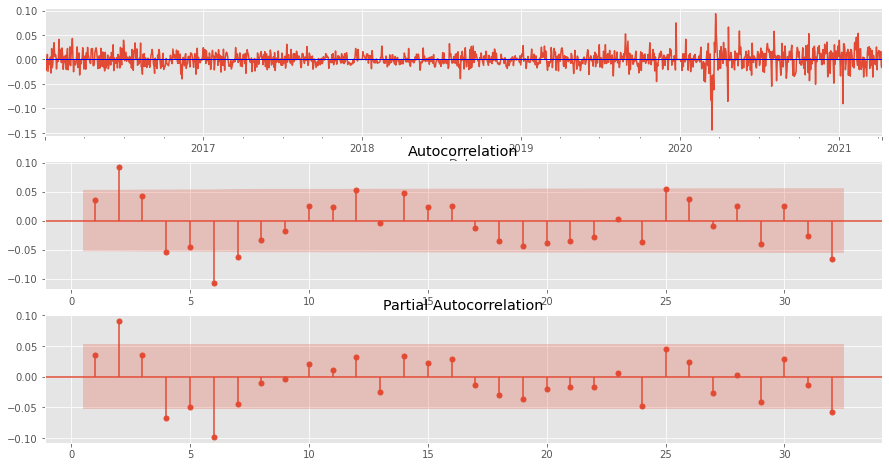

In [25]:
# plotting the first difference of log-returns
fig, ax = plt.subplots(3, 1, figsize=(15,8))
log_ret = plat_usd['plat_pm'].apply(np.log).diff().dropna()
log_ret.plot(ax=ax[0])
ax[0].axhline(0, c='blue', linewidth=1)

# plot pacf and acf for daily returns
plot_acf(log_ret, zero=False, ax=ax[1])
plot_pacf(log_ret, zero=False, ax=ax[2])

plt.show()

### Observation 4

For the Platinum price time series, it is less obvious that it is a random walk. Based on the results of ADF test above, we cannot reject the null hypothesis that a unit root is present. However, according to AIC the time series is more of an ARIMA(1,1,0) model, while we have a conflicting measure according to the BIC which suggests that it is a random walk. Further, a plot of its log returns also resembles that of white noise even though its ACF and PACF graphs show autocorrelation at higher lagged values. Finally, the model diagnostic graphs of an ARIMA(0,1,0) which plotted the distribution and correlogram of the model's residuals also raised some doubts on the quality of its fit. Overall, it is clear that the autocorrelations in the time series cannot be fully explained using an ARIMA model of either (1,1,0) or (0,1,0) orders.

## 4. Cointegration Analysis

In this section we discuss the potential cointegrating relationship between Palladium and Platinum prices at the daily level and attempt to build a mean reverting trading strategy based on that relationship including discovering the appropriate hedge ratio. It should be noted that while Palladium and Platinum are industrial substitutes, there may not be a cointegrating relationship between the pair OR we could also be faced with a situation where they are not cointegrating at the time frame for which we have data for.

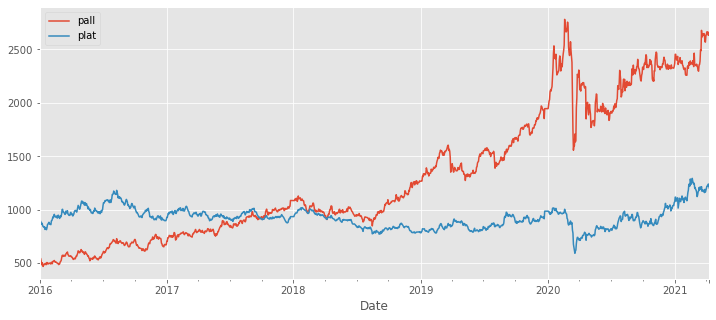

In [26]:
# plotting both palladium and platinum prices
fig = plt.figure(figsize=(12,5))

pall_usd['pall_pm'].plot(label='pall')
plat_usd['plat_pm'].plot(label='plat')

#plt.axvspan('2011-09',
#            '2015-01',
#            color='green',
#            alpha=0.3)

#plt.axvspan('2017-01',
#            '2020-07',
#            color='green',
#            alpha=0.3)

plt.legend()
plt.show()

Platinum prices were higher than Palladium until around Q4 2017. From 2H 2018, Palladium prices pushed strongly while Platinum traded roughly flat. An conintegrated relationship cannot be observed between the pair which is to be confirmed mathematically using linear regression of the two time series followed by testing the residuals of the models for stationarity.

In [27]:
pall_usd['pall_pm']

Date
2016-01-01     550.0
2016-01-04     550.0
2016-01-05     544.0
2016-01-06     519.0
2016-01-07     486.0
               ...  
2021-04-02    2664.0
2021-04-05    2664.0
2021-04-06    2664.0
2021-04-07    2632.0
2021-04-08    2650.0
Freq: B, Name: pall_pm, Length: 1375, dtype: float64

In [28]:
plat_usd['plat_pm'].iloc[0:-1]

Date
2016-01-01     893.0
2016-01-04     893.0
2016-01-05     893.0
2016-01-06     873.0
2016-01-07     865.0
               ...  
2021-04-02    1221.0
2021-04-05    1221.0
2021-04-06    1221.0
2021-04-07    1241.0
2021-04-08    1223.0
Freq: B, Name: plat_pm, Length: 1375, dtype: float64

The intercept is 1259.7035841471325 and the slope coefficient is 0.05469429635326774 for Palladium as dependent variable
The intercept is 923.798604137648 and the slope coefficient is 0.0013914161296427574 for Platinum as dependent variable
EG test statistic is 0.3525118694741028 and p-value is 0.9914469307055764


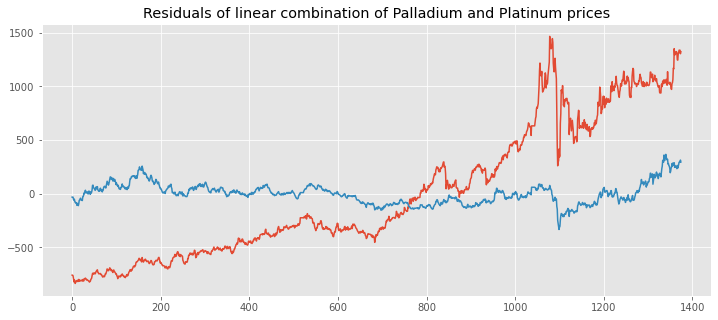

In [29]:
# perfroming conintegrated ADF
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

y = pall_usd['pall_pm'].values
x = plat_usd['plat_pm'].iloc[0:-1].values # PLAT price series has one more data point at the end

model1 = OLS(y, add_constant(x)).fit()
print('The intercept is {} and the slope coefficient is {} for Palladium as dependent variable'.format(model1.params[0], model1.params[1]))

model2 = OLS(x, add_constant(y)).fit()
print('The intercept is {} and the slope coefficient is {} for Platinum as dependent variable'.format(model2.params[0], model2.params[1]))

# sanity check for above result using statsmodel.coint function
eg = coint(pall_usd['pall_pm'], plat_usd['plat_pm'].iloc[0:-1])
print('EG test statistic is {} and p-value is {}'.format(eg[0], eg[1]))

# plotting the residuals of each linear regression
fig = plt.figure(figsize=(12,5))
plt.plot(model1.resid)
plt.plot(model2.resid)
plt.title('Residuals of linear combination of Palladium and Platinum prices')

plt.show()

## 5. Part 1 conclusion

As suggested in the last set of graphs, there is no cointegration between Palladium and Platinum daily prices over our period of study. We see that the residuals of the linear combination of Palladium and Platinum prices in either direction are not stationary. Hence, neither series can be fully explained by the other. This conclusion is further supported by the use of the statsmodels coint function on the two time series which returned a test statistic of 0.35 and p-value of 0.99 - not sufficient to reject the null hypothesis of no cointegrating relationship.